In [ ]:
## Gradient Boosting using Decision Trees

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
train_df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
eval_df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

In [4]:
tf.random.set_seed(21)

In [6]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hote_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab)
    )
    
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = train_df[feature_name].unique()
    feature_columns.append(
        one_hote_cat_column(feature_name, vocabulary)
    )
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(
        tf.feature_column.numeric_column(feature_name, dtype=tf.float32)
    )

In [7]:
example = dict(train_df.head(1))
class_fc = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third'))
)

print("Feature Value:", example['class'].iloc[0])
print('OHE:', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature Value: Third
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
OHE: [[0. 0. 1.]]


In [8]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

## Input Functions
- Input functions specify how the data will be read into our model
- Data reading for training and inference
- tf.data.from_tensor_slices method is used to read data directly from Pandas
- Suitable for smaller, in-memory datasets
- For larger datasets, tf.data supports variety of file formats
- Using those options, one can process datasets that do not fit in memory

In [14]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if(shuffle):
            dataset = dataset.shuffle(NUM_EXAMPLES)
        dataset = dataset.repeat(n_epochs)
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

train_input_fn = make_input_fn(train_df, y_train)
eval_input_fn = make_input_fn(eval_df, y_eval, shuffle=False, n_epochs=1)

In [15]:
linear_est = tf.estimator.LinearClassifier(feature_columns)
linear_est.train(train_input_fn, max_steps=100)

# Evaluation
result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


## Boosted Trees: Classification

In [16]:
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(
    feature_columns,
    n_batches_per_layer=n_batches
)
est.train(train_input_fn, max_steps=100)

result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.818182
accuracy_baseline         0.625000
auc                       0.859933
auc_precision_recall      0.850304
average_loss              0.419193
label/mean                0.375000
loss                      0.419193
precision                 0.774194
prediction/mean           0.379677
recall                    0.727273
global_step             100.000000
dtype: float64


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/wh/h43cl57j4ljf1x5_4p1bqmx80000gn/T/tmpy2o7yj1p/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


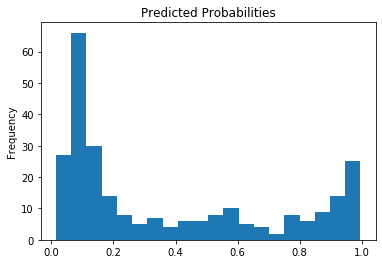

In [17]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='Predicted Probabilities')
plt.show()

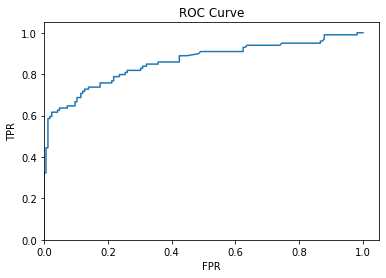

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0, )
plt.ylim(0, )
plt.show()